In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import warnings
import prophet
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings("ignore")
import keras

In [166]:
data = pd.read_csv('../data/regional_multivariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/multivariate/enc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
esc = pd.read_csv('../data/regional_datasets/multivariate/esc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
midatl = pd.read_csv('../data/regional_datasets/multivariate/mid_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
mount = pd.read_csv('../data/regional_datasets/multivariate/mountain_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
ne = pd.read_csv('../data/regional_datasets/multivariate/new_england_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
pac = pd.read_csv('../data/regional_datasets/multivariate/pacific_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
satl = pd.read_csv('../data/regional_datasets/multivariate/south_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wnc = pd.read_csv('../data/regional_datasets/multivariate/wnc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wsc = pd.read_csv('../data/regional_datasets/multivariate/wsc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(actual,forecast): 
    actual, forecast = np.array(actual), np.array(forecast)
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

In [59]:
def process(df):
    x = df.drop(columns = ['new_confirmed', 'region'] + [col for col in df.columns if col[0].isdigit()])
    lag1df = x.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df = df[['new_confirmed'] + [col for col in df.columns if col[0].isdigit()]].join(lag1df)
    return df.fillna(0)

In [60]:
enc1 = process(enc)
model = prophet.Prophet()
for col in enc1.columns:
    if col not in ['date', 'new_confirmed']:
        model.add_regressor(col)
model=model.fit(enc1.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

14:03:23 - cmdstanpy - INFO - Chain [1] start processing
14:03:23 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
enc1.columns[(abs(enc1.corr().new_confirmed) > 0.5)].drop('new_confirmed')

Index(['1_day_shift', '7_day_avg', '2_day_shift', '7_day_shift',
       'lag1_new_hospitalized_patients', 'lag1_current_hospitalized_patients'],
      dtype='object')

In [20]:
train_pred=model.predict(enc1.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
train_pred

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,1_day_shift,1_day_shift_lower,1_day_shift_upper,2_day_shift,2_day_shift_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-03-05,-274379.192640,-8290.466108,12398.579651,-274379.192640,-274379.192640,1158.157768,1158.157768,1158.157768,1637.195881,1637.195881,...,1029.120939,1029.120939,1029.120939,36032.044058,36032.044058,36032.044058,0.0,0.0,0.0,1782.337117
2020-03-06,-273715.171858,-12816.151298,8240.743411,-273715.171858,-273715.171858,1156.009662,1156.009662,1156.009662,1637.195881,1637.195881,...,1840.764604,1840.764604,1840.764604,35634.605392,35634.605392,35634.605392,0.0,0.0,0.0,-2623.847269
2020-03-07,-273051.151075,-16667.567244,5094.877268,-273051.151075,-273051.151075,1154.895830,1154.895830,1154.895830,1634.151556,1634.151556,...,-1205.071990,-1205.071990,-1205.071990,35267.747041,35267.747041,35267.747041,0.0,0.0,0.0,-5865.958796
2020-03-08,-272387.130293,-21033.714964,786.376491,-272387.130293,-272387.130293,1154.259355,1154.259355,1154.259355,1632.573018,1632.573018,...,-3211.397508,-3211.397508,-3211.397508,34936.167552,34936.167552,34936.167552,0.0,0.0,0.0,-10240.753974
2020-03-09,-271723.109510,-9852.355536,10935.811207,-271723.109510,-271723.109510,1153.065963,1153.065963,1153.065963,1631.670996,1631.670996,...,403.081595,403.081595,403.081595,34642.740819,34642.740819,34642.740819,0.0,0.0,0.0,506.033543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11,295350.661583,-1482.376910,18731.017403,295350.661583,295350.661583,1146.542088,1146.542088,1146.542088,1637.195881,1637.195881,...,403.081595,403.081595,403.081595,-7689.102445,-7689.102445,-7689.102445,0.0,0.0,0.0,8419.239650
2022-07-12,296014.682417,9500.083745,29742.874928,296014.682417,296014.682417,-388.557467,-388.557467,-388.557467,1620.733980,1620.733980,...,-1142.054831,-1142.054831,-1142.054831,-8199.110382,-8199.110382,-8199.110382,0.0,0.0,0.0,19933.706588
2022-07-13,296678.703250,9757.454322,29884.046140,296678.703250,296678.703250,-245.509579,-245.509579,-245.509579,-554.830266,-554.830266,...,2285.557192,2285.557192,2285.557192,-8715.540072,-8715.540072,-8715.540072,0.0,0.0,0.0,20337.349867


In [29]:
enc1.rename(columns = {'new_confirmed': 'yhat'}).reset_index()

,date,yhat,1_day_shift,7_day_avg,2_day_shift,7_day_shift,lag1_new_deceased,lag1_cumulative_confirmed,lag1_cumulative_deceased,lag1_new_hospitalized_patients,...,lag1_income_support,lag1_debt_relief,lag1_public_information_campaigns,lag1_testing_policy,lag1_contact_tracing,lag1_facial_coverings,lag1_vaccination_policy,lag1_stringency_index,lag1_minimum_temperature_celsius,lag1_maximum_temperature_celsius
0,2020-03-05,27.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000
1,2020-03-06,41.0,27.0,0.000000,0.0,0.0,0.0,106.0,1.0,0.0,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-7.461111,14.244444
2,2020-03-07,49.0,41.0,0.000000,27.0,0.0,0.0,147.0,1.0,0.0,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-5.494444,12.827778
3,2020-03-08,64.0,49.0,0.000000,41.0,0.0,0.0,196.0,1.0,0.0,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-11.422222,12.222222
4,2020-03-09,125.0,64.0,0.000000,49.0,0.0,0.0,260.0,1.0,0.0,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-2.700000,18.938889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,2022-07-11,19441.0,146.0,14254.142857,0.0,0.0,0.0,12481195.0,153297.0,590.0,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,8.544444,30.117284
859,2022-07-12,17643.0,19441.0,13736.142857,146.0,21269.0,64.0,12500636.0,153361.0,647.0,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,14.166667,31.654321
860,2022-07-13,18425.0,17643.0,13499.428571,19441.0,20082.0,148.0,12518279.0,153509.0,772.0,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,15.679012,30.511111
861,2022-07-14,31850.0,18425.0,14249.571429,17643.0,26599.0,71.0,12536704.0,153580.0,784.0,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,14.616667,31.211111


In [31]:
pd.concat([enc1.rename(columns = {'new_confirmed': 'yhat'}).reset_index().yhat,train_pred.reset_index().yhat], axis=1)

,yhat,yhat
0,27.0,1782.337117
1,41.0,-2623.847269
2,49.0,-5865.958796
3,64.0,-10240.753974
4,125.0,506.033543
...,...,...
858,19441.0,8419.239650
859,17643.0,19933.706588
860,18425.0,20337.349867
861,31850.0,23552.932728


<Axes: >

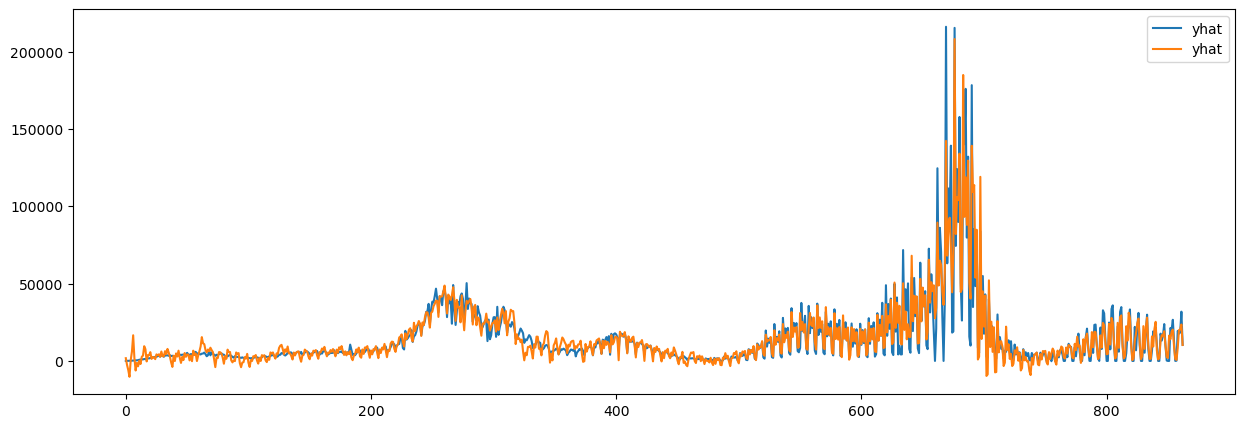

In [32]:
pd.concat([enc1.rename(columns = {'new_confirmed': 'yhat'}).reset_index().yhat,train_pred.reset_index().yhat], axis=1).plot(figsize=(15,5)) 

In [36]:
data

,new_confirmed,1_day_shift,7_day_avg,2_day_shift,7_day_shift,lag1_new_deceased,lag1_cumulative_confirmed,lag1_cumulative_deceased,lag1_new_hospitalized_patients,lag1_cumulative_hospitalized_patients,...,lag1_income_support,lag1_debt_relief,lag1_public_information_campaigns,lag1_testing_policy,lag1_contact_tracing,lag1_facial_coverings,lag1_vaccination_policy,lag1_stringency_index,lag1_minimum_temperature_celsius,lag1_maximum_temperature_celsius
date,,,,,,,,,,,,,,,,,,,,,
2020-03-05,27.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000
2020-03-06,41.0,27.0,0.000000,0.0,0.0,0.0,106.0,1.0,0.0,65586.95,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-7.461111,14.244444
2020-03-07,49.0,41.0,0.000000,27.0,0.0,0.0,147.0,1.0,0.0,63514.28,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-5.494444,12.827778
2020-03-08,64.0,49.0,0.000000,41.0,0.0,0.0,196.0,1.0,0.0,59644.23,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-11.422222,12.222222
2020-03-09,125.0,64.0,0.000000,49.0,0.0,0.0,260.0,1.0,0.0,68552.01,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-2.700000,18.938889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11,19441.0,146.0,14254.142857,0.0,0.0,0.0,12481195.0,153297.0,590.0,761162.00,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,8.544444,30.117284
2022-07-12,17643.0,19441.0,13736.142857,146.0,21269.0,64.0,12500636.0,153361.0,647.0,761809.00,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,14.166667,31.654321
2022-07-13,18425.0,17643.0,13499.428571,19441.0,20082.0,148.0,12518279.0,153509.0,772.0,762581.00,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,15.679012,30.511111


In [99]:
(abs(.drop(columns = 'ds').corr().y)).sort_values(ascending = False)

y                                                     1.000000
7_day_avg                                             0.833588
7_day_shift                                           0.772303
1_day_shift                                           0.695168
lag1_new_hospitalized_patients                        0.653818
lag1_current_hospitalized_patients                    0.582640
lag1_current_intensive_care_patients                  0.480851
lag1_cumulative_confirmed                             0.289988
lag1_international_travel_controls                    0.275822
lag1_dew_point                                        0.266037
lag1_cumulative_hospitalized_patients                 0.263835
lag1_average_temperature_celsius                      0.253547
lag1_cumulative_deceased                              0.243697
lag1_minimum_temperature_celsius                      0.238253
lag1_new_deceased                                     0.231774
lag1_school_closing                                   0

In [112]:
enc

,region,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,new_persons_vaccinated,...,contact_tracing,facial_coverings,vaccination_policy,stringency_index,minimum_temperature_celsius,maximum_temperature_celsius,1_day_shift,7_day_avg,2_day_shift,7_day_shift
date,,,,,,,,,,,,,,,,,,,,,
2020-03-05,East North Central,27.0,0.0,106.0,1.0,0.0,65586.95,3013.05,755.17,0.0,...,1.0,0.0,0.0,17.778,-7.461111,14.244444,NaN,NaN,NaN,NaN
2020-03-06,East North Central,41.0,0.0,147.0,1.0,0.0,63514.28,3106.85,784.39,0.0,...,1.0,0.0,0.0,17.778,-5.494444,12.827778,27.0,NaN,NaN,NaN
2020-03-07,East North Central,49.0,0.0,196.0,1.0,0.0,59644.23,3025.83,746.22,0.0,...,1.0,0.0,0.0,17.778,-11.422222,12.222222,41.0,NaN,27.0,NaN
2020-03-08,East North Central,64.0,0.0,260.0,1.0,0.0,68552.01,2667.92,667.38,0.0,...,1.0,0.0,0.0,17.778,-2.700000,18.938889,49.0,NaN,41.0,NaN
2020-03-09,East North Central,125.0,0.0,385.0,1.0,0.0,84213.22,2735.39,716.99,0.0,...,1.0,0.0,0.0,17.778,1.861111,18.011111,64.0,NaN,49.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11,East North Central,19441.0,64.0,12500636.0,153361.0,647.0,761809.00,3971.00,448.00,0.0,...,1.8,1.4,5.0,30.186,14.166667,31.654321,146.0,14254.142857,0.0,0.0
2022-07-12,East North Central,17643.0,148.0,12518279.0,153509.0,772.0,762581.00,4046.00,461.00,0.0,...,1.8,1.4,5.0,30.186,15.679012,30.511111,19441.0,13736.142857,146.0,21269.0
2022-07-13,East North Central,18425.0,71.0,12536704.0,153580.0,784.0,763365.00,4154.00,481.00,0.0,...,1.8,1.4,5.0,30.186,14.616667,31.211111,17643.0,13499.428571,19441.0,20082.0


13:18:29 - cmdstanpy - INFO - Chain [1] start processing
13:18:29 - cmdstanpy - INFO - Chain [1] done processing
13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing


East North Central
MASE:  0.3737282804863426


13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing


East South Central
MASE:  0.5432889763499786


13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing


Mid-Atlantic
MASE:  1.6737680827420256
Mountain
MASE:  0.8336917638424741


13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing
13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing


New England
MASE:  0.6955545624502824
Pacific
MASE:  1.2189835947045655


13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing
13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing


South Atlantic
MASE:  0.7152710021868083
West North Central
MASE:  0.8655547676851131


13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing


West South Central
MASE:  0.6254714509801631


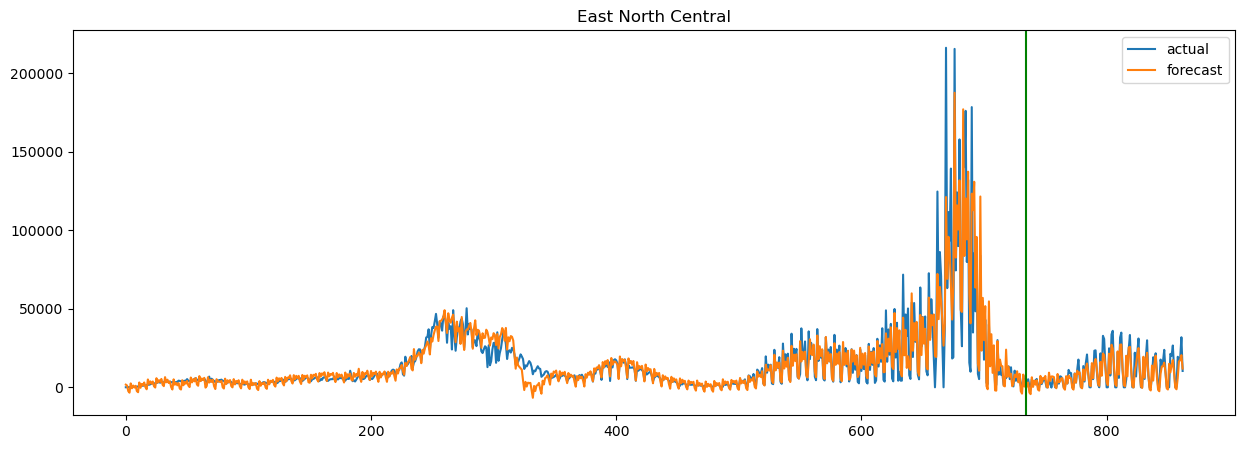

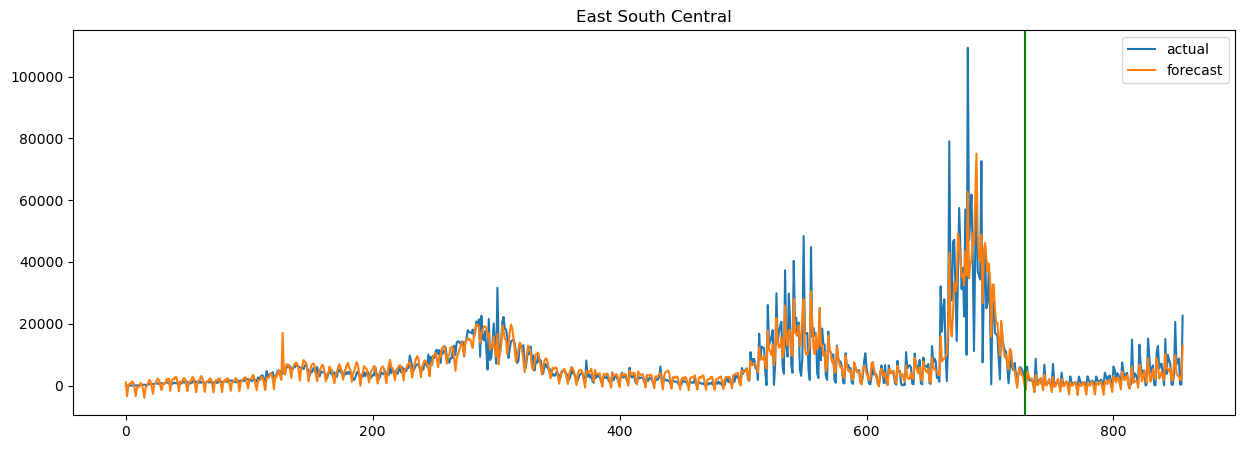

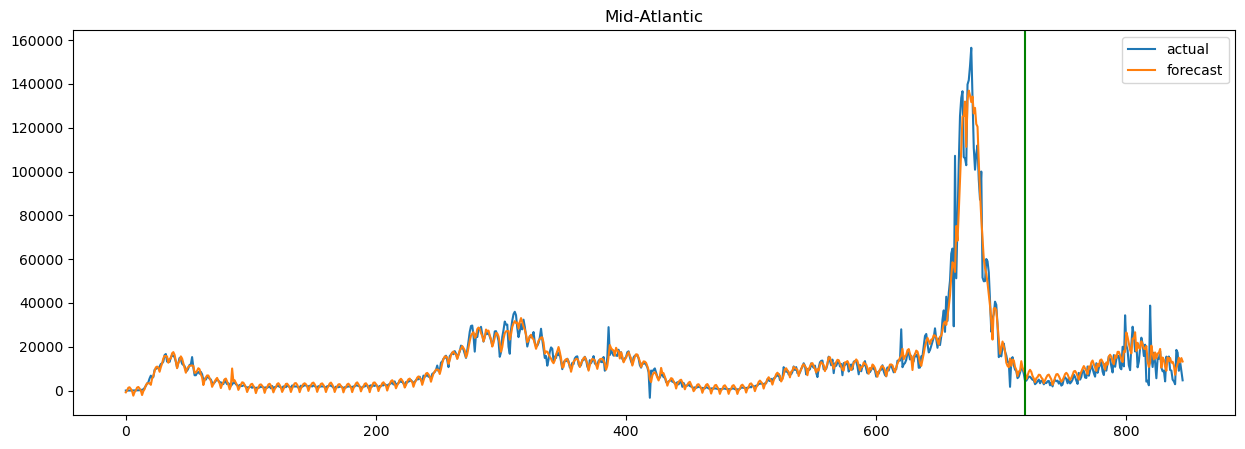

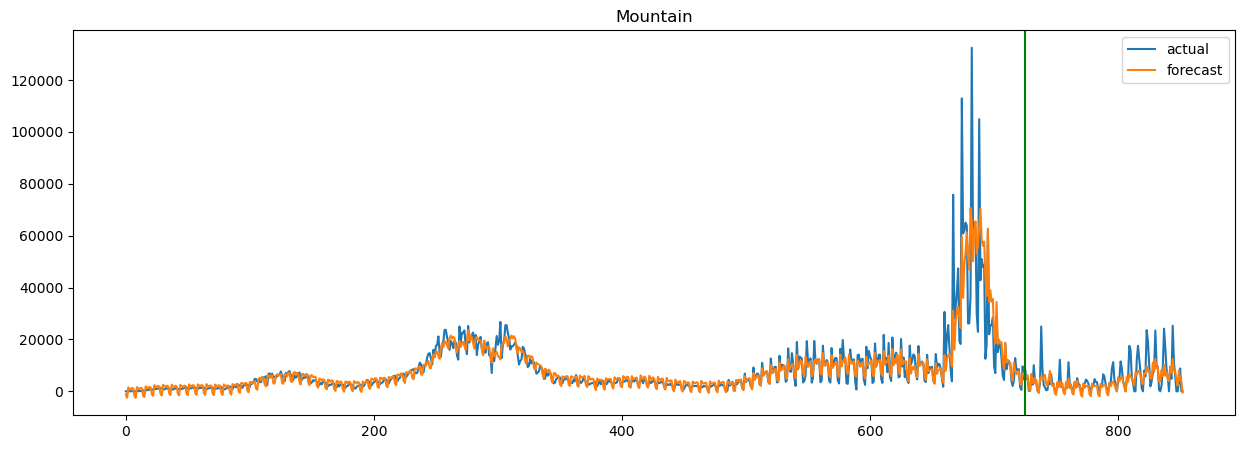

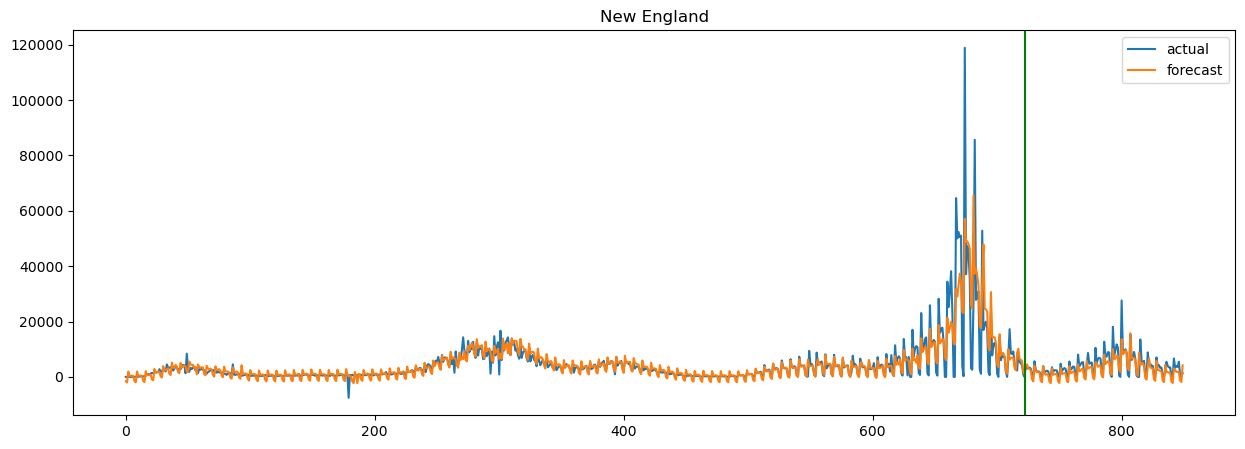

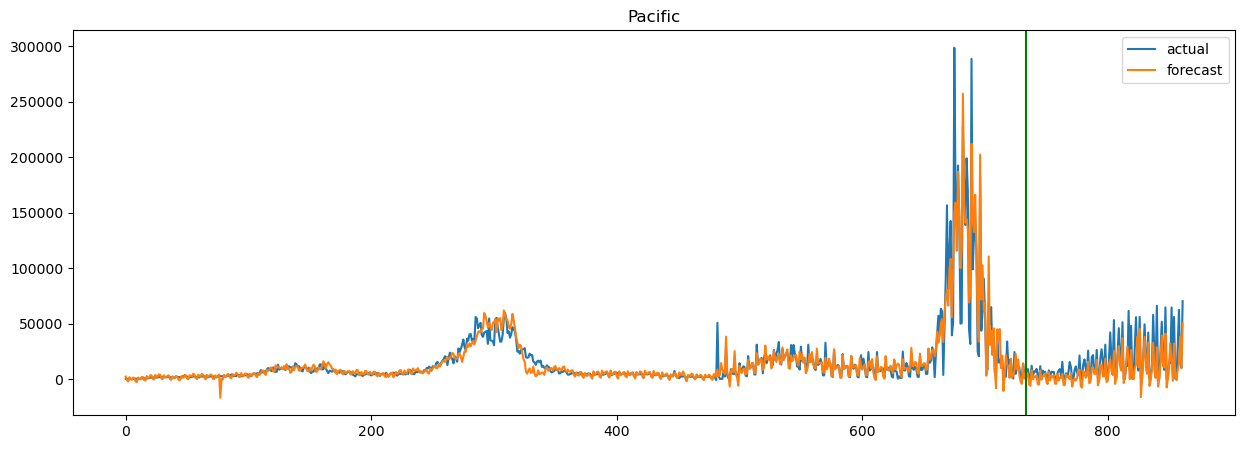

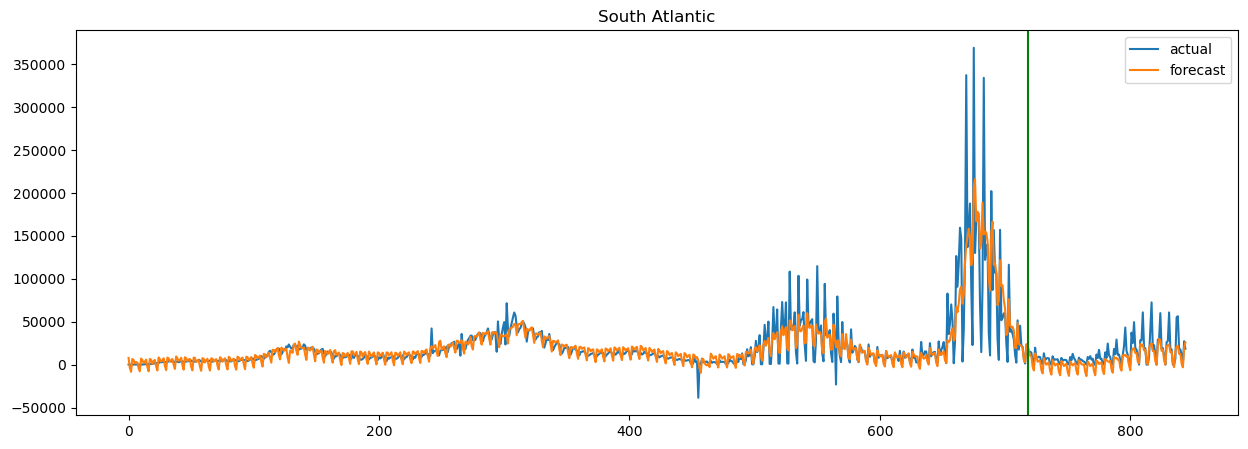

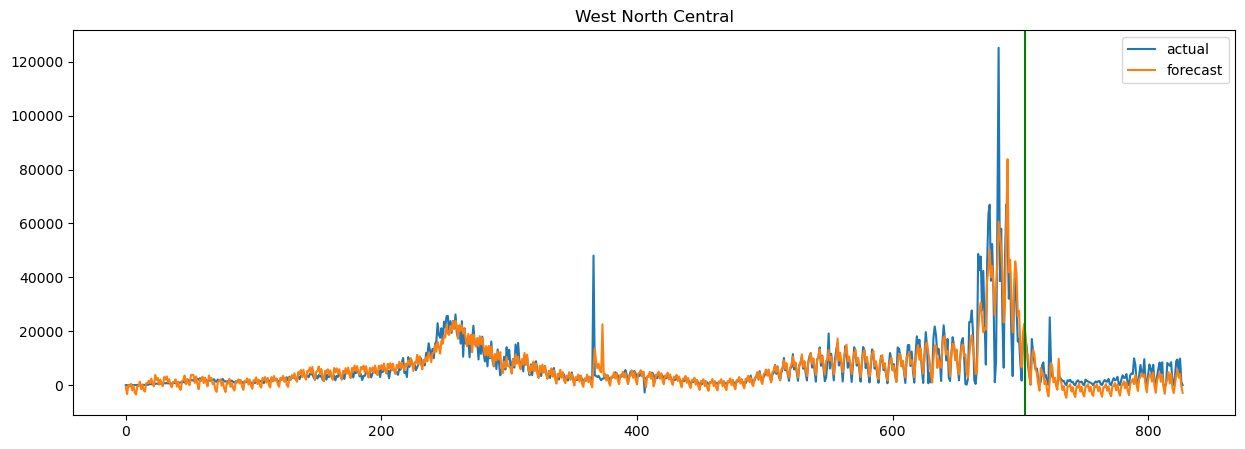

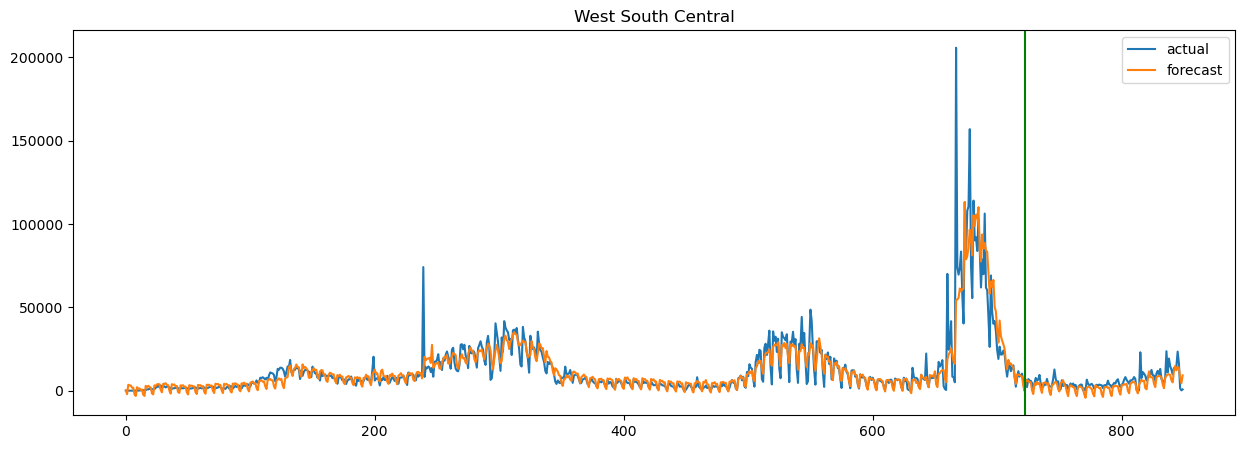

In [144]:
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    data = process(data1)
    # data = data1.drop(columns = ['region']).dropna()
    data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
    size = round(data.shape[0]*0.15)
    train = data.iloc[:-size]
    test = data.iloc[-size:]
    model = prophet.Prophet()
    for col in train.drop(columns = 'ds').columns[(abs(train.drop(columns = 'ds').corr().y) > 0.6)].drop('y'):
        if col not in ['ds', 'y']:
            model.add_regressor(col)
    model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    train_pred = model.predict(train)
    test_pred = model.predict(test)
    pd.concat([pd.concat([train.reset_index().y,train_pred.reset_index().yhat], axis=1),
            pd.concat([test.reset_index().y,test_pred.reset_index().yhat], axis=1)],
            axis = 0).reset_index().drop(columns = 'index').plot(figsize=(15,5))
    plt.axvline(x = len(train), color = 'g')
    print(data1.region.unique()[0])
    print("MASE: ", mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y))
    plt.legend(['actual', 'forecast'])
    plt.title(data1.region.unique()[0])

In [126]:
splitmases

[0.8594396152942281,
 0.8383680534919726,
 2.1439456131181203,
 3.288620624897965,
 3.3737826423372335]

In [103]:
best = dict()
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    mases = []
    print(data1.region.unique()[0])
    thresholds = np.linspace(0.5, 0.8, num = 10)
    for th in thresholds:
        data = process(data1)
        data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
        size = round(data.shape[0]*0.2)
        train = data.iloc[:-size]
        test = data.iloc[-size:]
        model = prophet.Prophet()
        for col in train.drop(columns = 'ds').columns[(abs(train.drop(columns = 'ds').corr().y) > th)].drop('y'):
            if col not in ['ds', 'y']:
                model.add_regressor(col)
        model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
        train_pred = model.predict(train)
        test_pred = model.predict(test)
        mases.append(mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y))
        # plt.legend(['actual', 'forecast'])
        # plt.title(data1.region.unique()[0])
    print(np.min(mases))
    print(thresholds[np.argmin(mases)])
    best[data1.region.unique()[0]] = [np.min(mases), thresholds[np.argmin(mases)]]

22:48:20 - cmdstanpy - INFO - Chain [1] start processing
22:48:20 - cmdstanpy - INFO - Chain [1] done processing


East North Central


22:48:20 - cmdstanpy - INFO - Chain [1] start processing
22:48:20 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:22 - cmdstanpy - INFO - Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1] done processing
22:48:22 - cmdstanpy - INFO - Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1]

1.0181315590776145
0.7000000000000001
East South Central


22:48:22 - cmdstanpy - INFO - Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing
22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing
22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1]

1.2552733926370128
0.6333333333333333
Mid-Atlantic


22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing
22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing
22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing
22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1]

2.8037042530854115
0.5
Mountain


22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing
22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1]

2.258636049623347
0.5
New England


22:48:28 - cmdstanpy - INFO - Chain [1] done processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] 

2.313174126615097
0.6
Pacific


22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1]

2.141604044153074
0.5666666666666667
South Atlantic


22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:33 - cmdstanpy - INFO - Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1] done processing
22:48:33 - cmdstanpy - INFO - Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1] done processing
22:48:33 - cmdstanpy - INFO - Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1]

2.1884481243202467
0.8
West North Central


22:48:33 - cmdstanpy - INFO - Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1]

2.0288826669081663
0.7666666666666667
West South Central


22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1]

1.8830070055150367
0.8


13:16:02 - cmdstanpy - INFO - Chain [1] start processing
13:16:02 - cmdstanpy - INFO - Chain [1] done processing
13:16:02 - cmdstanpy - INFO - Chain [1] start processing
13:16:02 - cmdstanpy - INFO - Chain [1] done processing
13:16:03 - cmdstanpy - INFO - Chain [1] start processing
13:16:03 - cmdstanpy - INFO - Chain [1] done processing


East North Central
MASE:  2.217116301169026
RMSE:  20725.055481909036
MAE:  19218.54181915184


13:16:03 - cmdstanpy - INFO - Chain [1] start processing
13:16:03 - cmdstanpy - INFO - Chain [1] done processing
13:16:03 - cmdstanpy - INFO - Chain [1] start processing
13:16:03 - cmdstanpy - INFO - Chain [1] done processing


East South Central
MASE:  6.090135705853522
RMSE:  22300.655446981757
MAE:  22082.321067666882


13:16:03 - cmdstanpy - INFO - Chain [1] start processing
13:16:03 - cmdstanpy - INFO - Chain [1] done processing
13:16:04 - cmdstanpy - INFO - Chain [1] start processing
13:16:04 - cmdstanpy - INFO - Chain [1] done processing


Mid-Atlantic
MASE:  24.405506608926608
RMSE:  56266.64239899815
MAE:  55711.755188917916


13:16:04 - cmdstanpy - INFO - Chain [1] start processing
13:16:04 - cmdstanpy - INFO - Chain [1] done processing
13:16:04 - cmdstanpy - INFO - Chain [1] start processing
13:16:04 - cmdstanpy - INFO - Chain [1] done processing
13:16:04 - cmdstanpy - INFO - Chain [1] start processing


Mountain
MASE:  8.261664277596209
RMSE:  28134.84705450239
MAE:  27611.885585762644


13:16:04 - cmdstanpy - INFO - Chain [1] done processing
13:16:04 - cmdstanpy - INFO - Chain [1] start processing
13:16:04 - cmdstanpy - INFO - Chain [1] done processing


New England
MASE:  7.524699007830069
RMSE:  20788.995082024678
MAE:  20366.010105483772


13:16:05 - cmdstanpy - INFO - Chain [1] start processing
13:16:05 - cmdstanpy - INFO - Chain [1] done processing
13:16:05 - cmdstanpy - INFO - Chain [1] start processing
13:16:05 - cmdstanpy - INFO - Chain [1] done processing
13:16:05 - cmdstanpy - INFO - Chain [1] start processing


Pacific
MASE:  3.364983104629724
RMSE:  25380.897590293218
MAE:  24139.998050040016


13:16:05 - cmdstanpy - INFO - Chain [1] done processing
13:16:05 - cmdstanpy - INFO - Chain [1] start processing
13:16:05 - cmdstanpy - INFO - Chain [1] done processing
13:16:05 - cmdstanpy - INFO - Chain [1] start processing


South Atlantic
MASE:  6.48745762625207
RMSE:  76218.597562384
MAE:  75212.18164893739


13:16:05 - cmdstanpy - INFO - Chain [1] done processing
13:16:05 - cmdstanpy - INFO - Chain [1] start processing
13:16:05 - cmdstanpy - INFO - Chain [1] done processing
13:16:06 - cmdstanpy - INFO - Chain [1] start processing
13:16:06 - cmdstanpy - INFO - Chain [1] done processing


West North Central
MASE:  9.618460347712325
RMSE:  33654.28366301006
MAE:  33014.82470371639
West South Central
MASE:  8.782147934050125
RMSE:  42970.532865043686
MAE:  42654.015518939086


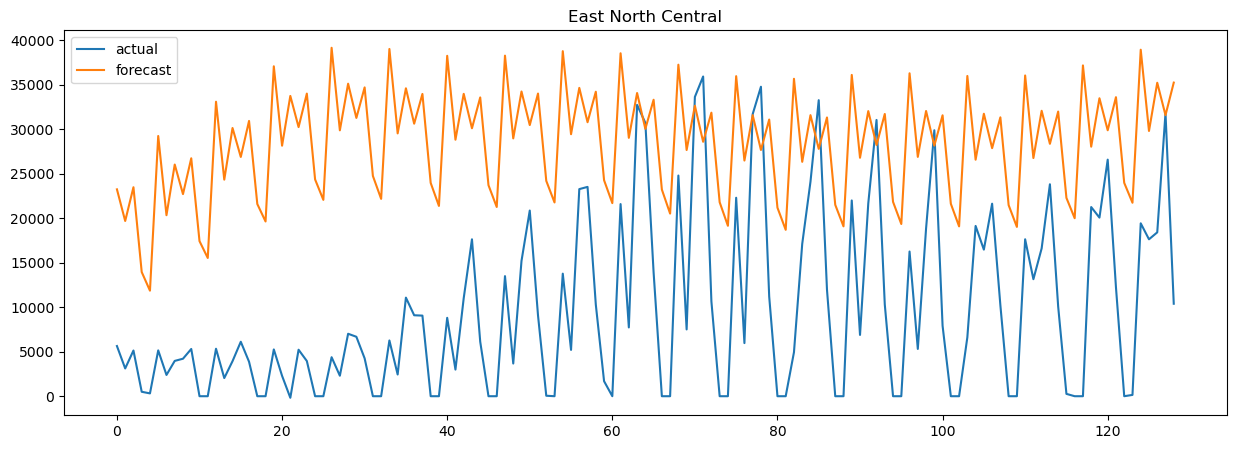

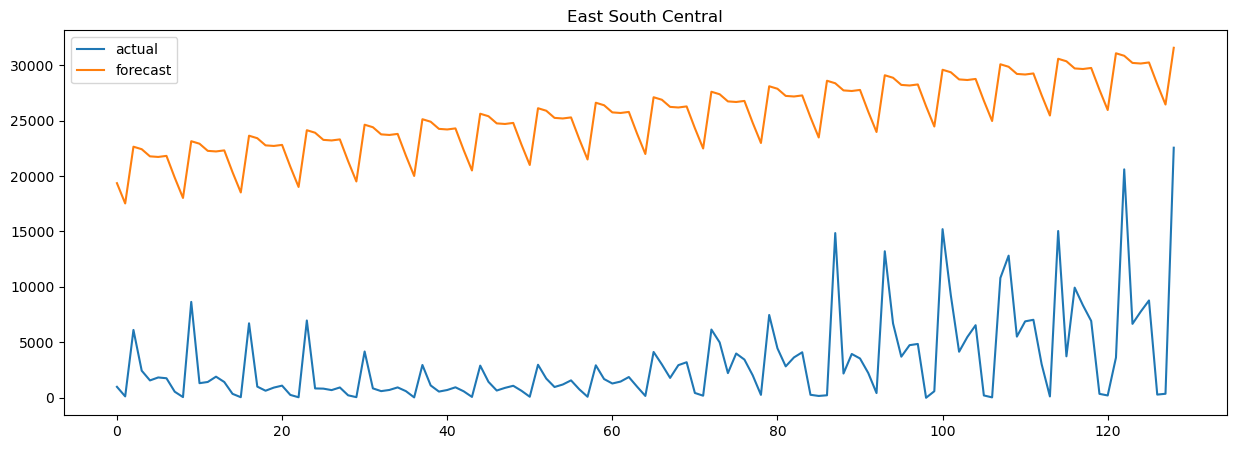

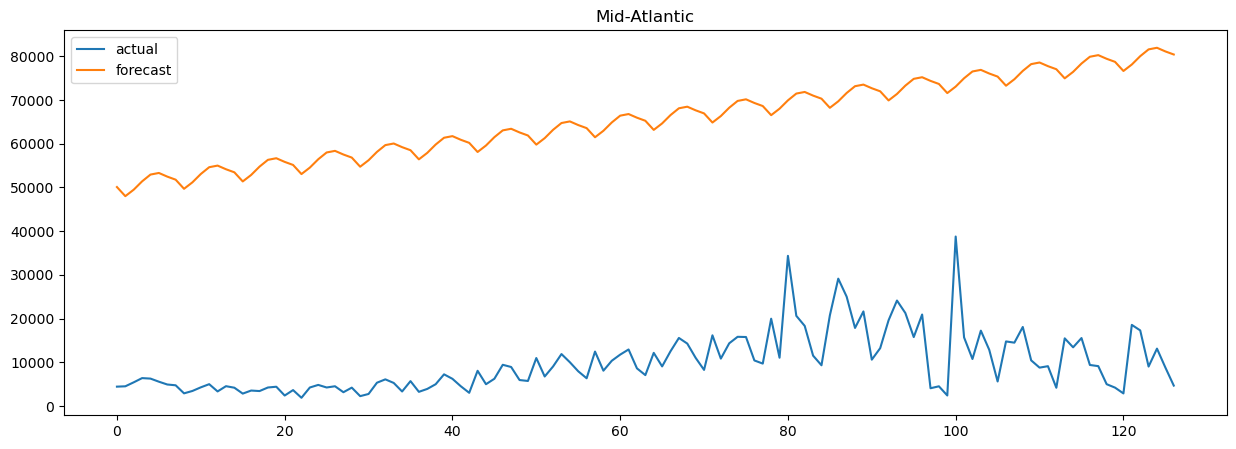

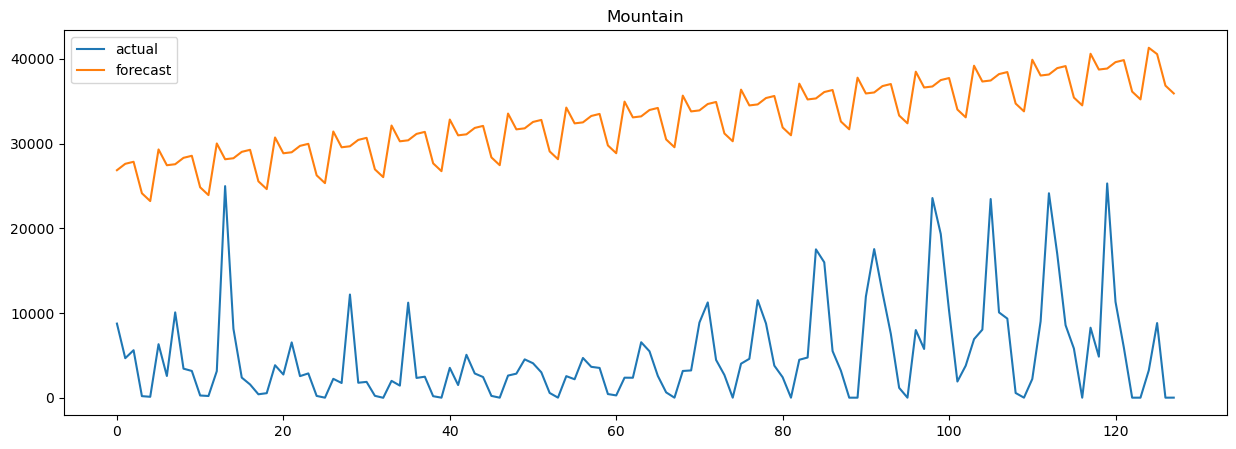

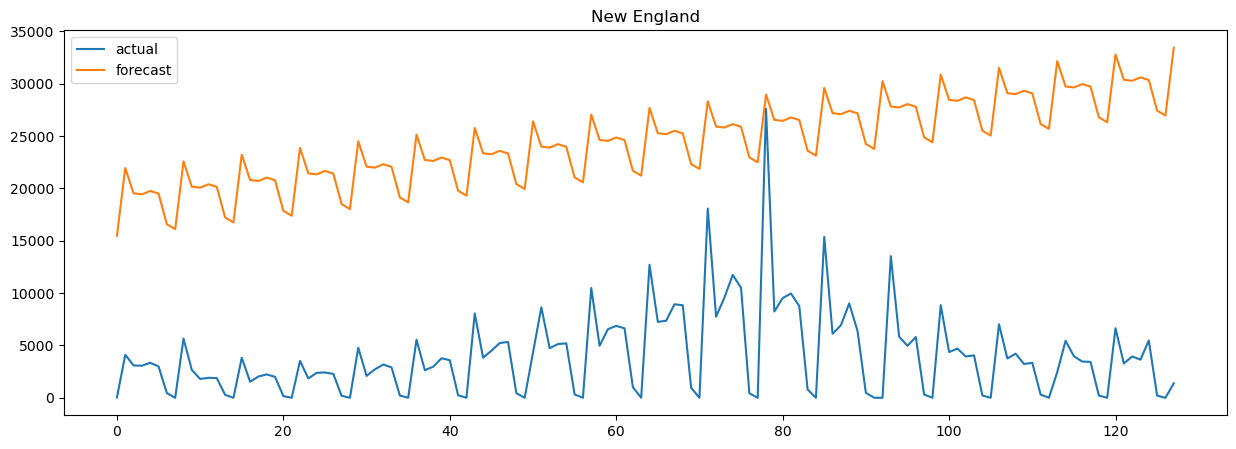

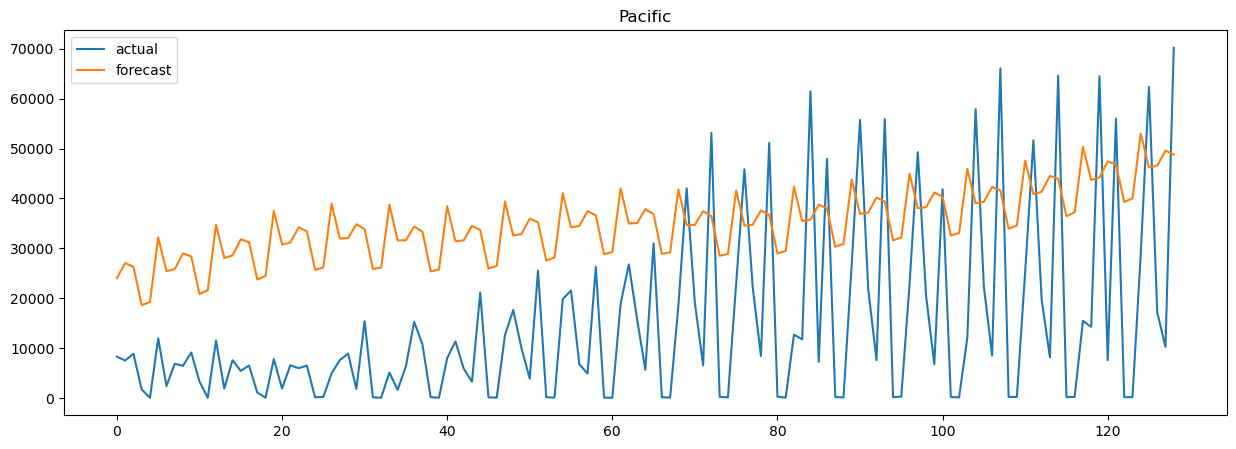

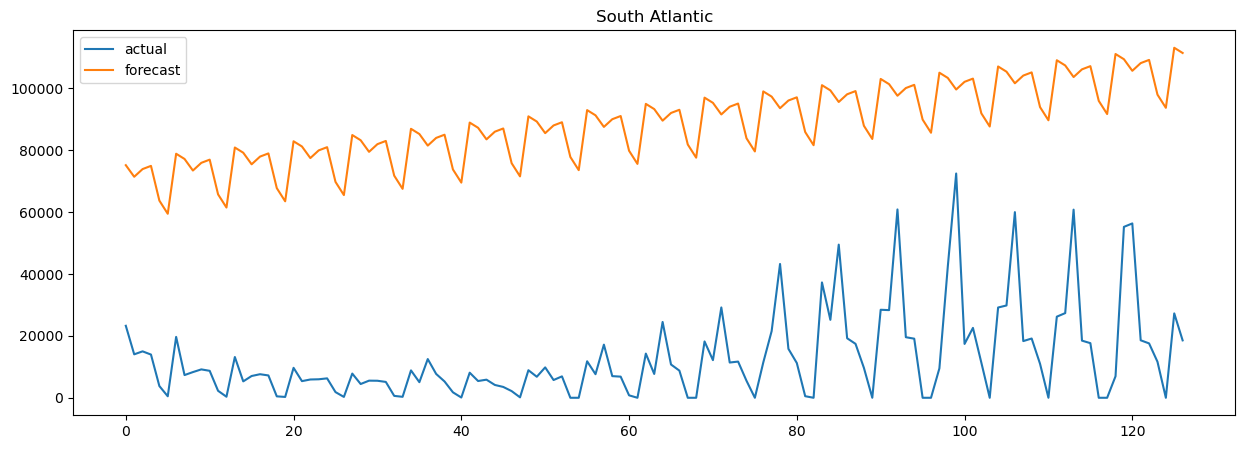

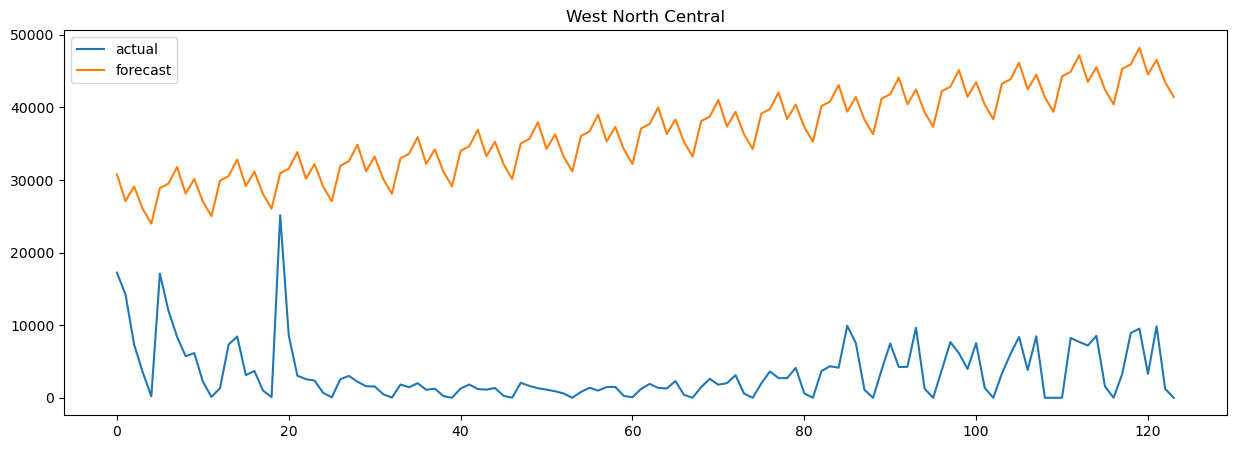

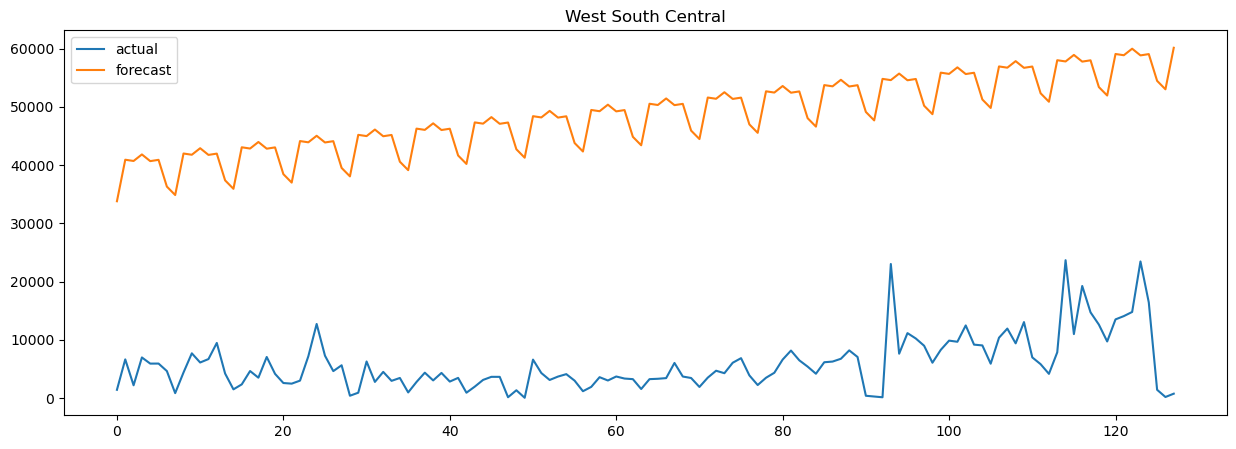

In [160]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import random
params_grid = {'changepoint_prior_scale':[0.05],
               'seasonality_prior_scale':[10]}
grid = ParameterGrid(params_grid)
best_params = []
best_mase = []
best_rmse = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
# for data1 in [enc]:
    data = process(data1)
    # data = data1.drop(columns = ['region']).dropna()
    data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
    size = round(data.shape[0]*0.15)
    train = data.iloc[:-size]
    test = data.iloc[-size:]
    mases = []
    params = []
    rmses = []
    for p in grid:
        params.append(p)
        model = prophet.Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                                seasonality_prior_scale=p['seasonality_prior_scale'])
        for col in train.drop(columns = 'ds').columns[(abs(train.drop(columns = 'ds').corr().y) > 0.5)].drop('y'):
            if col not in ['ds', 'y']:
                model.add_regressor(col)
        model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
        train_pred = model.predict(train)
        test_pred = model.predict(test)
        masetemp = mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y)
        mases.append(masetemp)
        rmsetemp = mean_squared_error(test.y, test_pred.yhat, squared = False)
        rmses.append(rmsetemp)
    best_mase.append(min(mases))
    best_params.append(params[np.argmin(mases)])
    best_rmse.append(min(rmses))
    model = prophet.Prophet(changepoint_prior_scale=params[np.argmin(mases)]['changepoint_prior_scale'],
                            seasonality_prior_scale=params[np.argmin(mases)]['seasonality_prior_scale']).fit(train)
    train_pred = model.predict(train)
    test_pred = model.predict(test)
    train_pred['yhat'] = train_pred['yhat'].apply(lambda x: max(0, x))
    test_pred['yhat'] = test_pred['yhat'].apply(lambda x: max(0, x))
    plt.figure(figsize = (15,5))
    plt.plot(test.reset_index().y)
    plt.plot(test_pred.yhat)
    # pd.concat([pd.concat([train.y,train_pred.yhat], axis=1),
    #            pd.concat([test.reset_index().y,test_pred.yhat], axis=1)],
    #            axis = 0).reset_index().drop(columns = 'index').plot(figsize=(15,5))
    # plt.axvline(x = len(train), color = 'g')
    print(data1.region.unique()[0])
    print('MASE: ', mean_absolute_scaled_error(test.reset_index().y, test_pred.yhat, y_train = train.y))
    print('RMSE: ', mean_squared_error(test.reset_index().y, test_pred.yhat, squared = False))
    print('MAE: ', mean_absolute_error(test.reset_index().y, test_pred.yhat))
    plt.legend(['actual', 'forecast'])
    plt.title(data1.region.unique()[0])


16:13:34 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1] done processing
16:13:34 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1] done processing


East North Central
MASE:  0.34519331860126207
RMSE:  4655.6591538000785
MAE:  2992.225633690109


16:13:34 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1] done processing


East South Central
MASE:  0.3702489740041717
RMSE:  2163.625741960789
MAE:  1342.491713456576


16:13:35 - cmdstanpy - INFO - Chain [1] start processing
16:13:35 - cmdstanpy - INFO - Chain [1] done processing


Mid-Atlantic
MASE:  1.5013391045544073
RMSE:  4903.238358858174
MAE:  3427.187068425419


16:13:35 - cmdstanpy - INFO - Chain [1] start processing
16:13:35 - cmdstanpy - INFO - Chain [1] done processing


Mountain
MASE:  0.9036778917750233
RMSE:  4848.785660458926
MAE:  3020.2450396998192


16:13:35 - cmdstanpy - INFO - Chain [1] start processing
16:13:35 - cmdstanpy - INFO - Chain [1] done processing


New England
MASE:  0.7480698212856042
RMSE:  2810.175179793473
MAE:  2024.69195433021


16:13:36 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing


Pacific
MASE:  1.0600395353413374
RMSE:  12425.810801242955
MAE:  7604.6005345162075


16:13:36 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing


South Atlantic
MASE:  0.6439755143362313
RMSE:  11440.773603015272
MAE:  7465.914407784155


16:13:36 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing


West North Central
MASE:  0.5939478578110264
RMSE:  3289.0953722974514
MAE:  2038.692649332673
West South Central
MASE:  0.4561539585707766
RMSE:  3439.3641155532264
MAE:  2215.494224649251


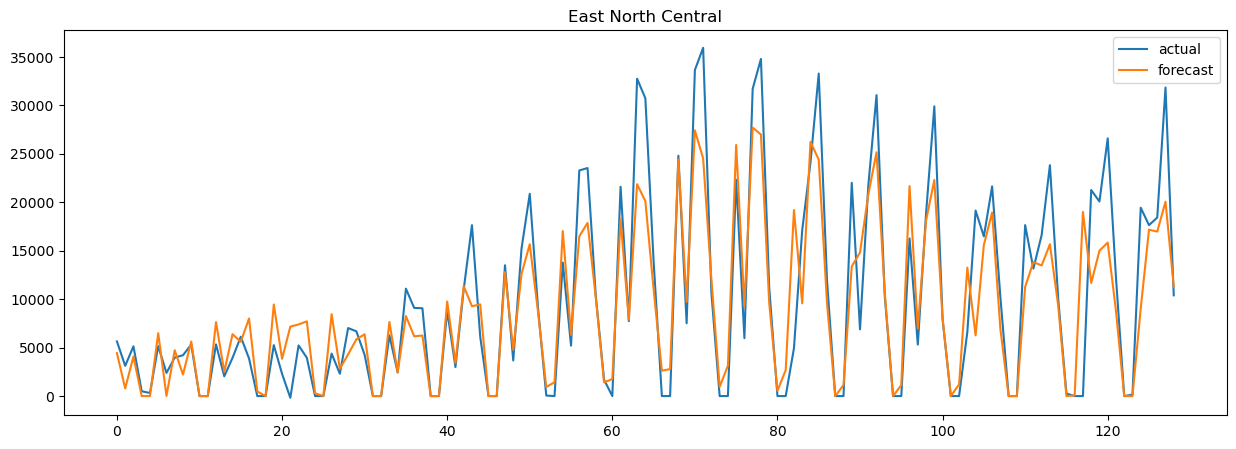

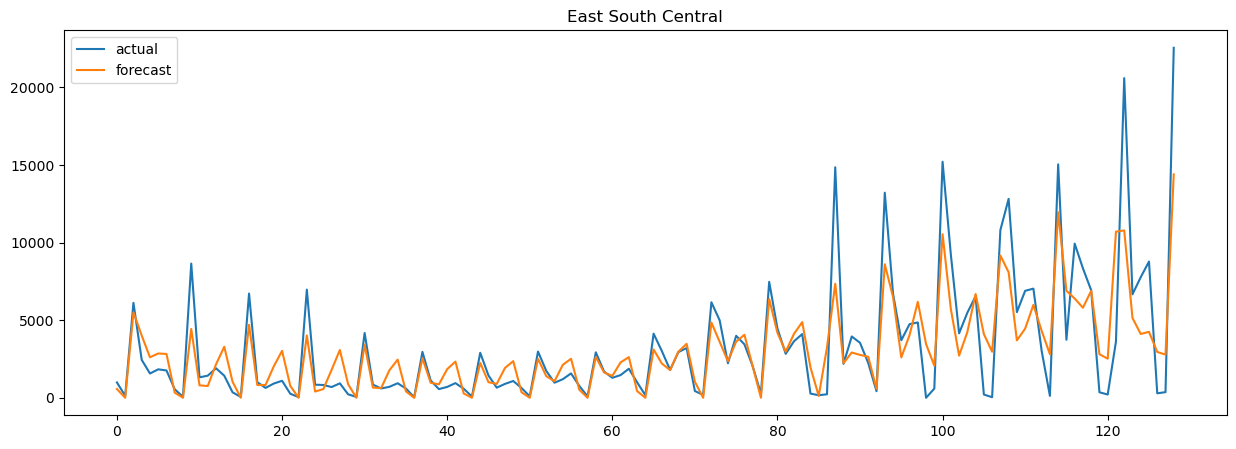

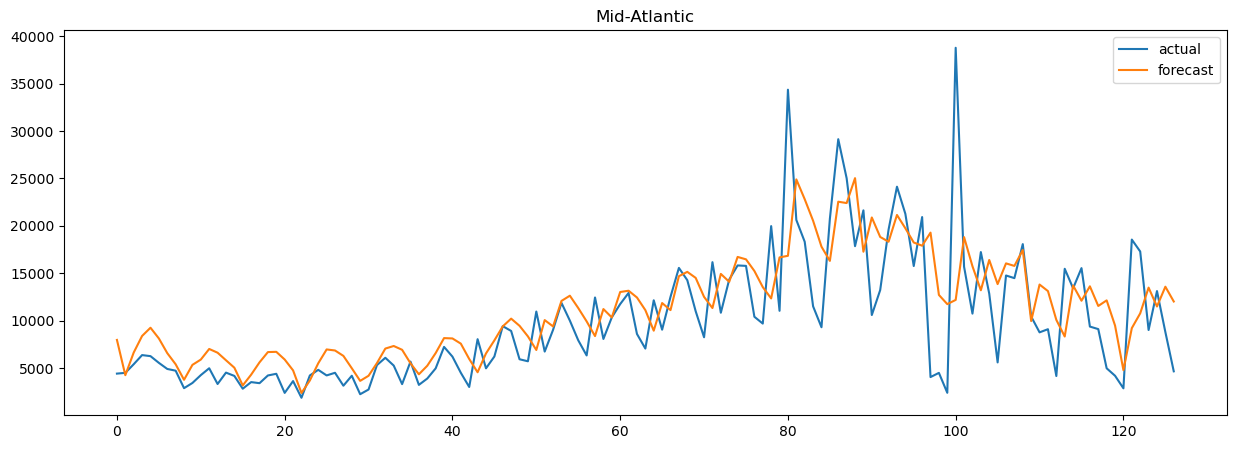

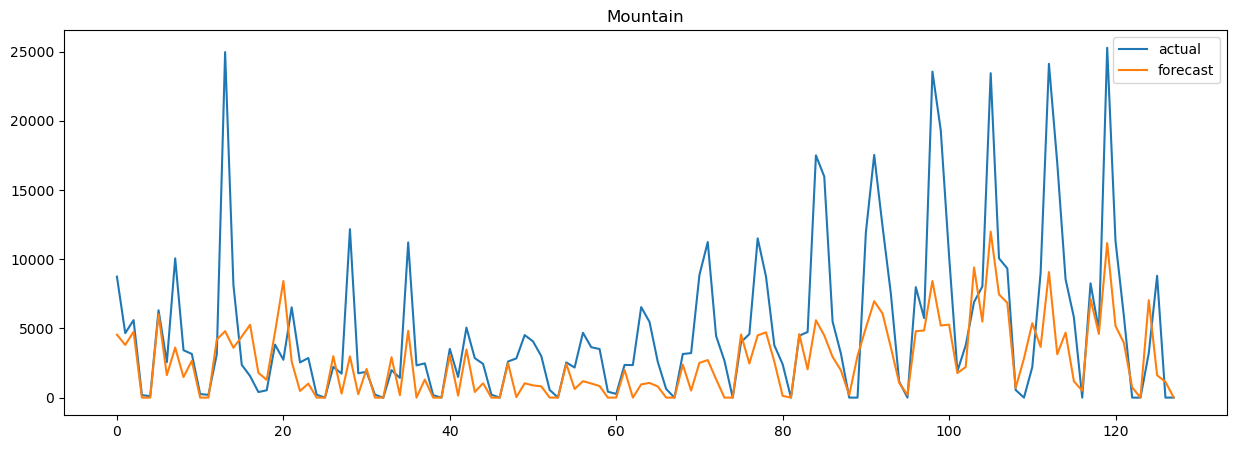

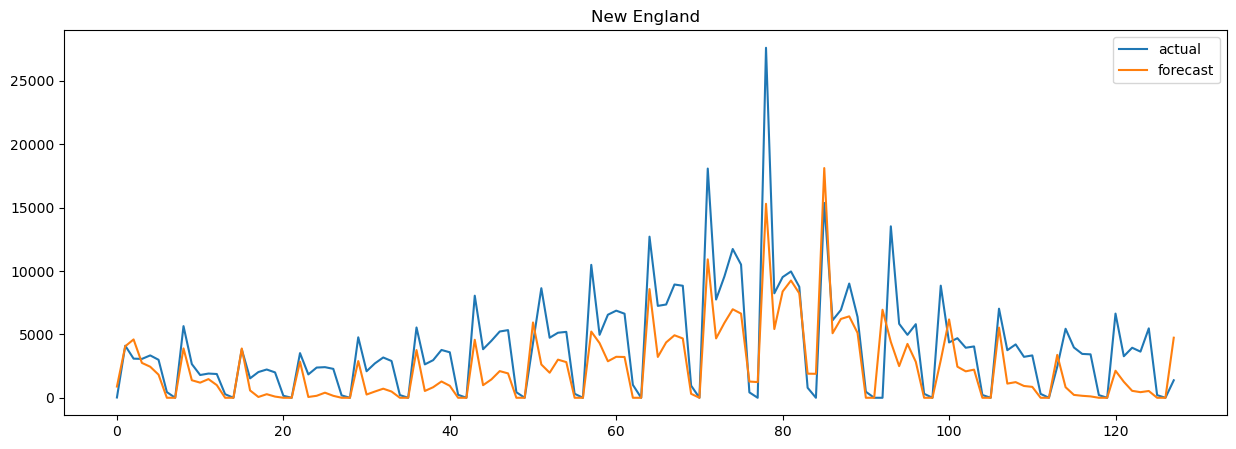

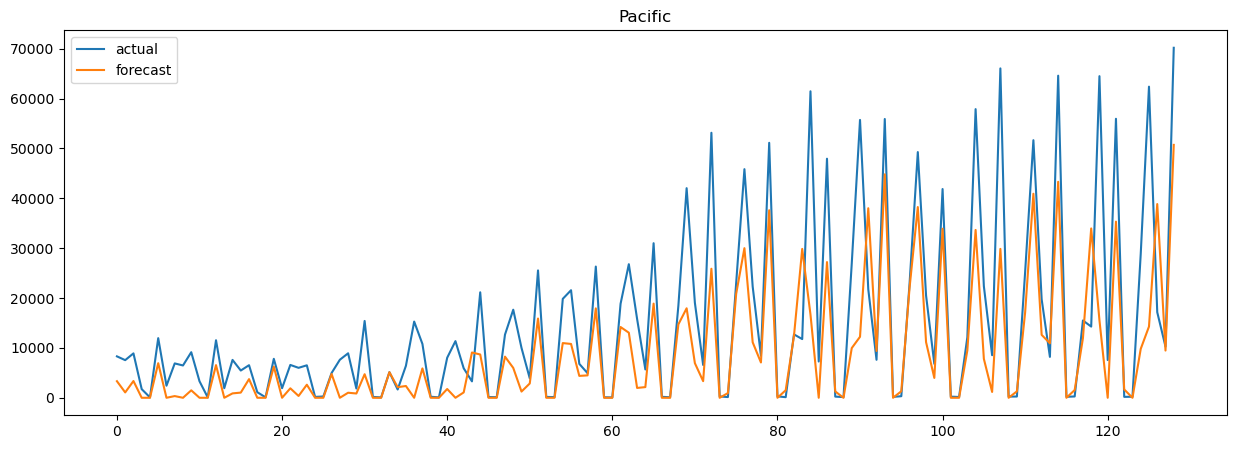

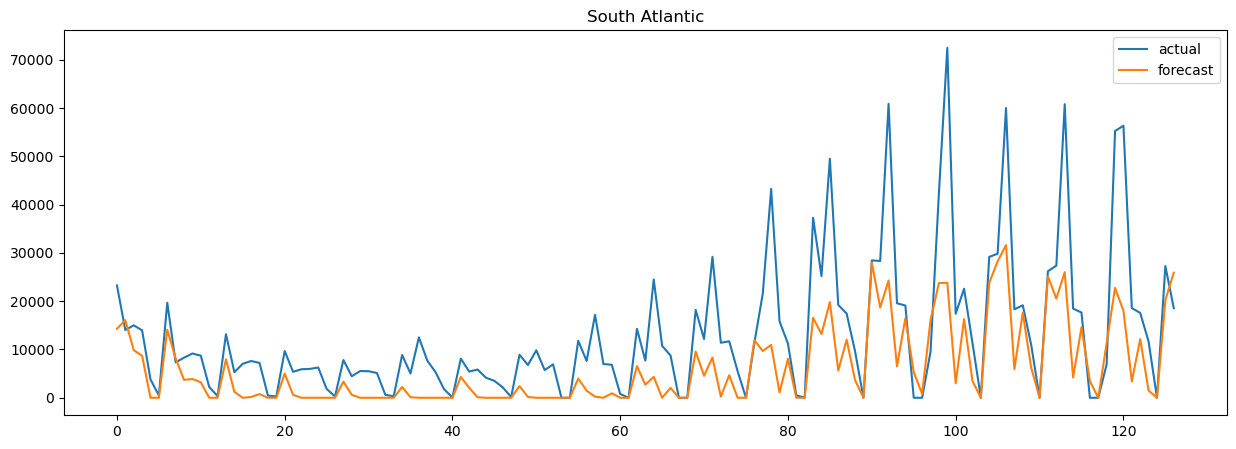

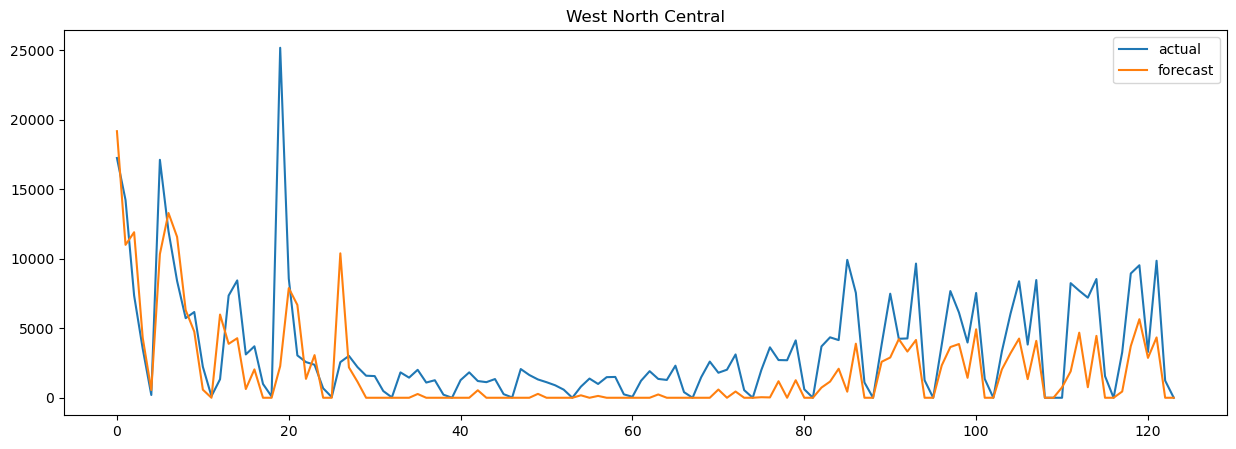

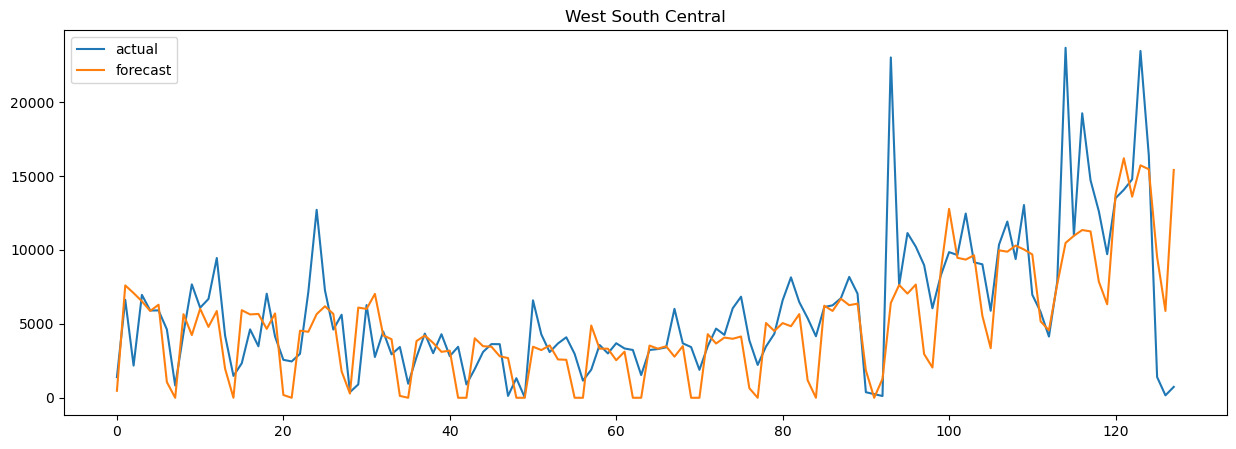

In [164]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import random
best_mase = []
best_rmse = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
# for data1 in [enc]:
    data = process(data1)
    # data = data1.drop(columns = ['region']).dropna()
    data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
    size = round(data.shape[0]*0.15)
    train = data.iloc[:-size]
    test = data.iloc[-size:]
    model = prophet.Prophet()
    model.add_country_holidays(country_name='US')
    for col in train.drop(columns = 'ds').columns[(abs(train.drop(columns = 'ds').corr().y) > 0.5)].drop('y'):
        if col not in ['ds', 'y']:
            model.add_regressor(col)
    model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    train_pred = model.predict(train)
    test_pred = model.predict(test)
    masetemp = mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y)
    rmsetemp = mean_squared_error(test.y, test_pred.yhat, squared = False)
    best_mase.append(masetemp)
    best_rmse.append(rmsetemp)
    train_pred['yhat'] = train_pred['yhat'].apply(lambda x: max(0, x))
    test_pred['yhat'] = test_pred['yhat'].apply(lambda x: max(0, x))
    plt.figure(figsize = (15,5))
    plt.plot(test.reset_index().y)
    plt.plot(test_pred.yhat)
    # pd.concat([pd.concat([train.y,train_pred.yhat], axis=1),
    #            pd.concat([test.reset_index().y,test_pred.yhat], axis=1)],
    #            axis = 0).reset_index().drop(columns = 'index').plot(figsize=(15,5))
    # plt.axvline(x = len(train), color = 'g')
    print(data1.region.unique()[0])
    print('MASE: ', mean_absolute_scaled_error(test.reset_index().y, test_pred.yhat, y_train = train.y))
    print('RMSE: ', mean_squared_error(test.reset_index().y, test_pred.yhat, squared = False))
    print('MAE: ', mean_absolute_error(test.reset_index().y, test_pred.yhat))
    plt.legend(['actual', 'forecast'])
    plt.title(data1.region.unique()[0])


In [158]:
best_mase

[0.38090405056034204,
 0.4232208486854831,
 1.5593883750332962,
 0.9892424534080357,
 0.7975181421405588,
 1.2263165298949874,
 0.7300670747642295,
 0.8655547676851131,
 0.6254714509801631]

In [136]:
 pd.concat([pd.concat([train.y,train_pred.yhat], axis=1),
               pd.concat([test.reset_index().y,test_pred.yhat], axis=1)],
               axis = 0).reset_index().drop(columns = 'index')

,y,yhat
0,27.0,0.000000
1,41.0,1500.625230
2,49.0,0.000000
3,64.0,0.000000
4,125.0,6258.278892
...,...,...
858,19441.0,24953.505909
859,17643.0,15780.876698
860,18425.0,21114.042495
861,31850.0,17436.592369


In [168]:
data.region.value_counts()

region
East North Central    863
Pacific               862
East South Central    857
Mountain              853
New England           850
West South Central    850
Mid-Atlantic          846
South Atlantic        845
West North Central    828
Name: count, dtype: int64